# Загрузка библиотек и данных

In [12]:
%pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.4/165.4 kB 1.4 MB/s eta 0:00:00m eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 5.6 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 3.5 MB/s eta 0:00:004.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 1.6 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip is available: 23.3 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
import opendatasets as od
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import sklearn

np.random.RandomState(seed=42)
plt.style.use("bmh")

In [15]:
od.download("https://www.kaggle.com/datasets/surajjha101/cuisine-rating")
dataset_df = pd.read_csv('./cuisine-rating/Cuisine_rating.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Skipping, found downloaded files in "./cuisine-rating" (use force=True to force download)
Full train dataset shape is (200, 15)


# Смотрим данные, ищем за что зацепиться

In [3]:
dataset_df = dataset_df.drop(["User ID", "Location"], axis=1)

# little reindexing to cut off ratings by [:-3] inxexing
col_list = list(dataset_df)
col_list[-1], col_list[-4] = col_list[-4], col_list[-1]
dataset_df = dataset_df.reindex(columns=col_list)
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area code       200 non-null    int64  
 1   Gender          200 non-null    object 
 2   YOB             200 non-null    int64  
 3   Marital Status  200 non-null    object 
 4   Activity        200 non-null    object 
 5   Budget          200 non-null    int64  
 6   Cuisines        200 non-null    object 
 7   Alcohol         200 non-null    object 
 8   Smoker          200 non-null    object 
 9   Often A S       200 non-null    object 
 10  Service Rating  200 non-null    int64  
 11  Overall Rating  200 non-null    float64
 12  Food Rating     200 non-null    int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 20.4+ KB


In [4]:
dataset_df.head()

,Area code,Gender,YOB,Marital Status,Activity,Budget,Cuisines,Alcohol,Smoker,Often A S,Service Rating,Overall Rating,Food Rating
0,153,Female,2006,Single,Professional,3,Japanese,Never,Never,No,4,4.5,5
1,123,Female,1991,Married,Student,3,Indian,Never,Socially,No,1,1.0,1
2,122,Male,1977,Single,Student,5,Seafood,Often,Often,Yes,5,5.0,5
3,153,Female,1956,Married,Professional,5,Japanese,Never,Socially,No,1,2.0,3
4,129,Male,1997,Single,Student,4,Filipino,Socially,Never,No,4,3.0,2


<Axes: xlabel='Overall Rating', ylabel='Count'>

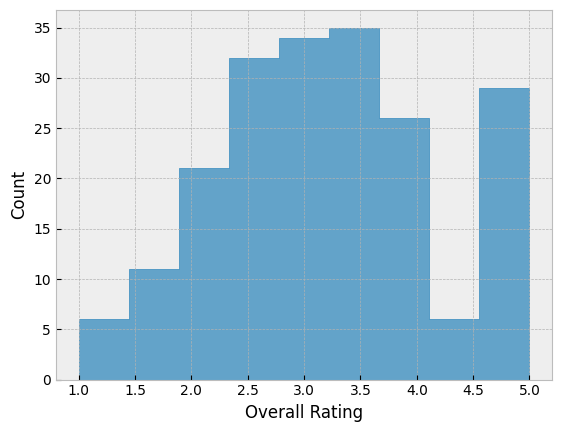

In [5]:
sns.histplot(data=dataset_df["Overall Rating"], element="step")

In [6]:
num_dataset = dataset_df.copy()
for col in num_dataset:
    if num_dataset[col].dtype in ["int64", "float64"]:
        continue
    num_dataset[col] = num_dataset[col].rank().astype(int)

In [8]:
dataset_corr = num_dataset.corr()["Overall Rating"][:-3]

real_features = dataset_corr.sort_values(ascending=False)
real_features

Often A S         0.312748
Alcohol           0.207072
Cuisines          0.078830
YOB               0.057508
Smoker            0.051304
Marital Status    0.017904
Area code        -0.008142
Budget           -0.058049
Gender           -0.085445
Activity         -0.165879
Name: Overall Rating, dtype: float64

Низкоая корелляция какая-то... Всего 200 записей, похоже будет сложно получить хорошее предсказание

# Идем по моделям

In [35]:
from sklearn.model_selection import train_test_split

label = "Overall Rating"

dataset_df.rename(columns = {"Overall Rating": "O_R", "Area code": "A_C", "Marital Status": "M_S", "Often A S": "O_A_S"}, inplace=True)

num_dataset = dataset_df.copy()
for col in num_dataset:
    if num_dataset[col].dtype in ["int64", "float64"]:
        continue
    num_dataset[col] = num_dataset[col].rank().astype(int)


X_train, X_test, y_train, y_test = train_test_split(num_dataset.drop("O_R", axis=1), num_dataset["O_R"])

print("{} examples in training, {} examples in testing.".format(
    len(X_train), len(X_test)))

150 examples in training, 50 examples in testing.


In [36]:
X_train.head()

,User ID,A_C,Location,Gender,YOB,M_S,Activity,Budget,Cuisines,Alcohol,Smoker,O_A_S
105,106,172,45,141,1995,150,140,5,189,44,94,87
21,22,153,167,41,1983,57,40,5,133,175,30,87
6,7,111,45,41,1977,57,40,5,108,119,165,87
157,158,196,30,141,1962,57,40,3,41,44,30,87
94,95,111,45,141,1974,57,140,3,108,119,94,187


In [46]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

clf = BayesianRidge()
clf.fit(X_train, y_train)

y_predicted=clf.predict(X_test)

mean_squared_error(y_true=y_test, y_pred=y_predicted)

1.112847193351189

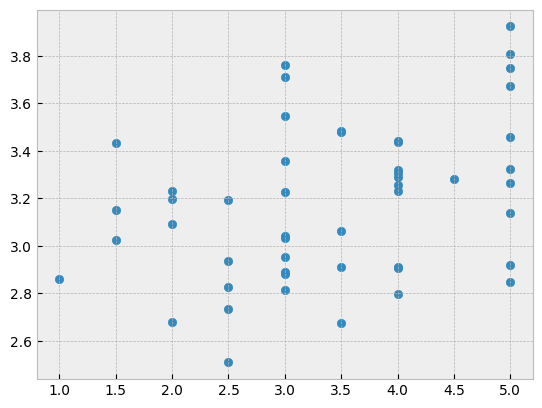

In [48]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_predicted)